# APEX Gun Comparison

In [1]:
%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pmd_beamphysics import ParticleGroup, single_particle, particle_paths
from pmd_beamphysics.labels import mathlabel
from pmd_beamphysics.units import pg_units

from distgen import Generator

from pytao import Tao

from impact import Impact

import h5py

## Parameters

In [3]:
GUN_PHASE_DEG = 10

## Initial Particle(s)

Pick one of these

In [4]:
# Single particle
P0 = single_particle(x=1000e-6, z=1e-9, pz=1e-9)

PFILE = 'initial_particles.h5'

In [5]:
DISTGEN_IN = """
n_particle: 100
random_type: hammersley

start:
  type: cathode
  MTE:
    units: meV
    value: 250
    
total_charge:
  units: pC
  value: 100

r_dist:
  type: radial_uniform
  max_r:
    units: mm
    value: 0.5
  
t_dist:
  type: gaussian
  avg_t:
    units: ps
    value: 0
  sigma_t:
    units: ps
    value: 8.5
  n_sigma_cutoff: 3
  
"""
D = Generator(DISTGEN_IN)
D.run()
P0 = D.particles
P0

<ParticleGroup with 100 particles at 0x16639e3d0>

In [6]:
P0.write(PFILE)

## Bmad

In [7]:
tao = Tao(f'-init bmad/tao.init -noplot -beam_init_position_file {PFILE}')

In [8]:
# Set the phase
tao.cmd(f'set ele GUN phi0 = {GUN_PHASE_DEG}/360')

[]

In [9]:
%%time
# Toggle beam
tao.cmd(f'set beam_init n_particle = {len(P0)}')
tao.cmd('set global track_type = beam')
tao.cmd('set global track_type = single')

CPU times: user 5.81 s, sys: 11.3 s, total: 17.1 s
Wall time: 2.93 s


[]

In [10]:
# Gather particles
with h5py.File('beam_dump.h5', 'r') as h5:
    ppaths = particle_paths(h5)
    Plist = [ParticleGroup(h5[g]) for g in ppaths]
    
Pf = Plist[-1]

In [11]:
# Get the absolute phase used
a = tao.ele_gen_attribs('GUN')
PHASE_DEG =(a['PHI0_AUTOSCALE'] + a['PHI0'])*360
PHASE_DEG

91.40633835954762

## Impact-T

In [12]:
%%time
I = Impact('impact/ImpactT-2D.in', initial_particles=P0)

I.ele['APEX_gun']['theta0_deg'] = PHASE_DEG + 90  
I.run()

CPU times: user 84.6 ms, sys: 27.5 ms, total: 112 ms
Wall time: 397 ms


# Compare Stats

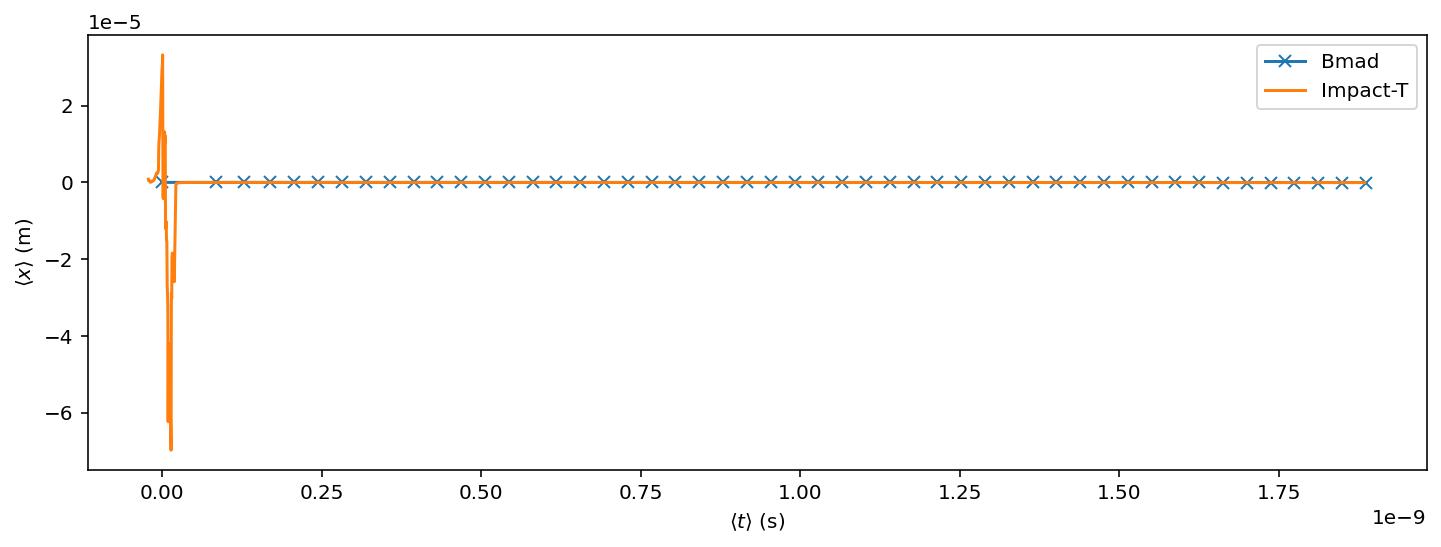

In [13]:
def compare_stat(key):

    fig, ax = plt.subplots(figsize=(12,4))
    
    ky = key
    
    kx = 'mean_t'
    bmadx = np.array([P[kx] for P in Plist])
    bmady = np.array([P[ky] for P in Plist])    
    
    ax.plot(bmadx, bmady, label='Bmad', marker='x')
    ax.plot(I.stat('t'), I.stat(ky), label='Impact-T')
    
    ax.set_ylabel(mathlabel(ky, units=pg_units(ky)))
    ax.set_xlabel(mathlabel(kx, units=pg_units(kx)))
    plt.legend()
    #plt.ylim(0, None)
    
compare_stat('mean_x')    

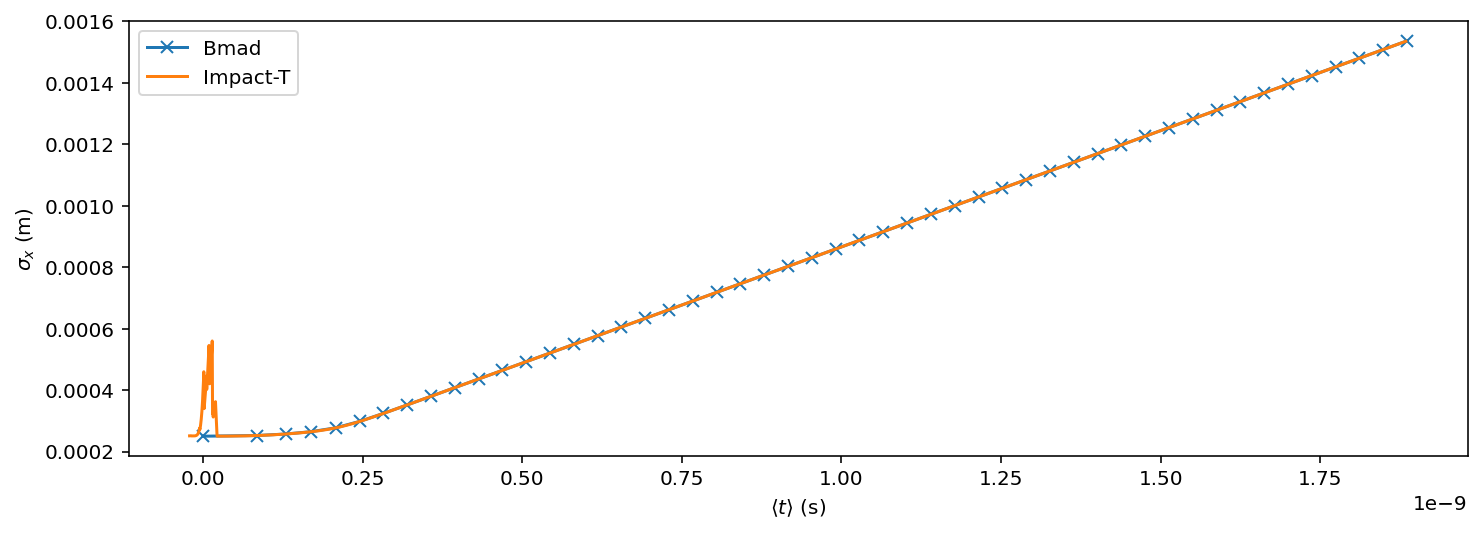

In [14]:
compare_stat('sigma_x')  

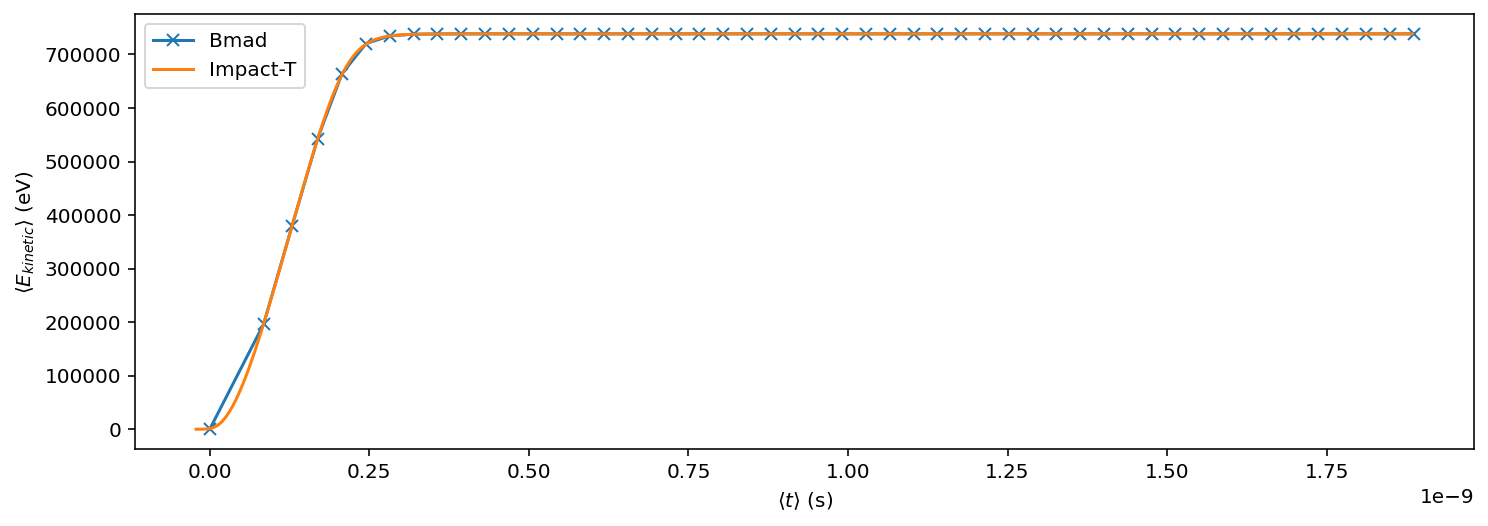

In [15]:
compare_stat('mean_kinetic_energy')  

# Compare final particles

In [16]:
PfI = I.particles['final_particles']
PfI.drift_to_z(0.5) # to make the comparisons the same

PfB = Plist[-1]

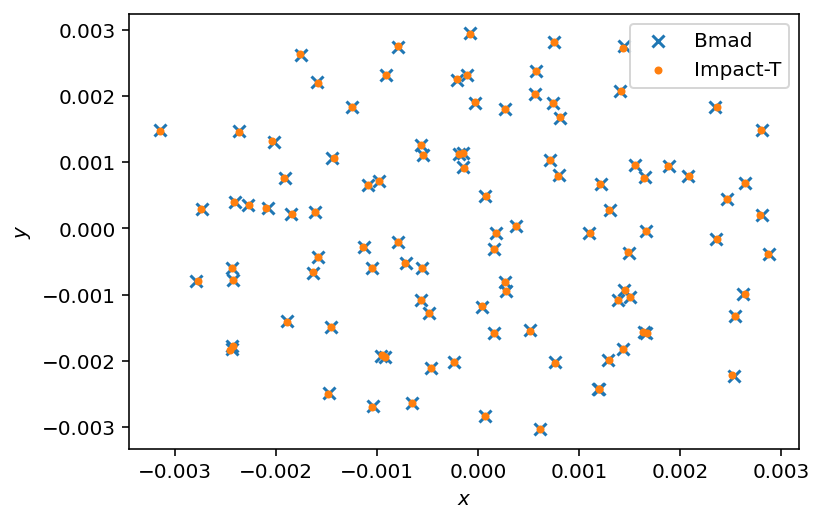

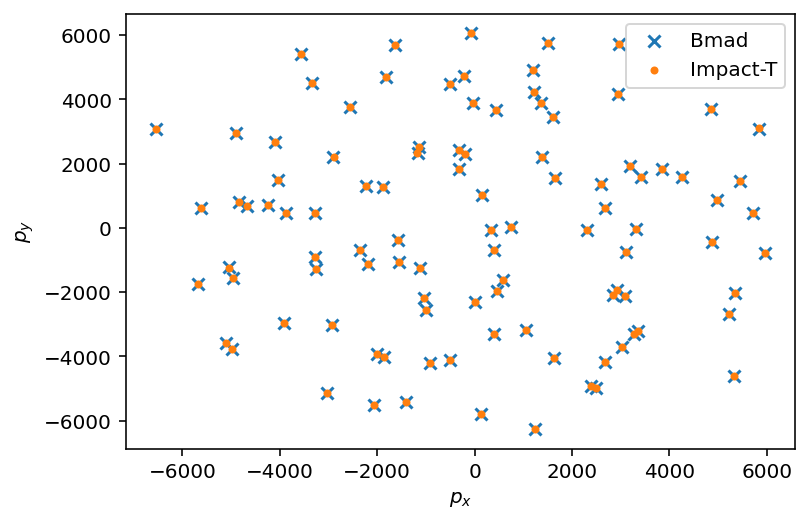

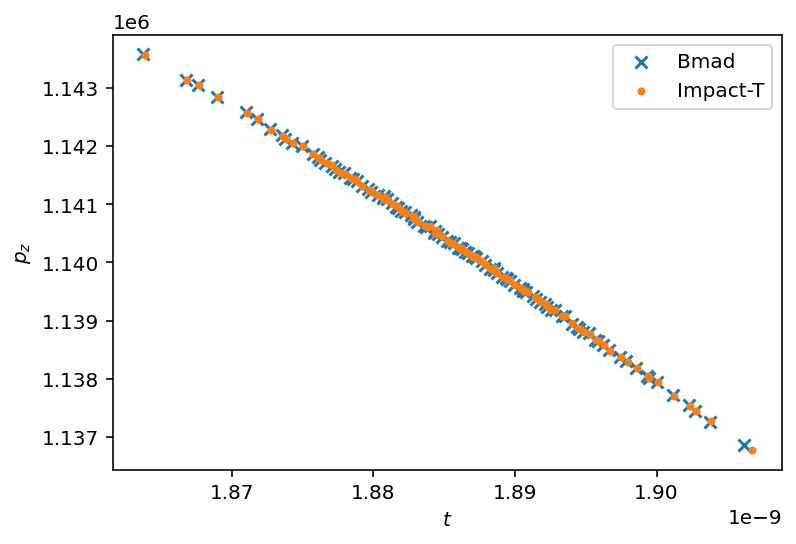

In [17]:
def compare_particles(k1, k2):
    
    plist=(PfB, PfI)
    labels=('Bmad', 'Impact-T')
    markers=('x', '.')
    
    fig, ax = plt.subplots()
    for P, label, marker in zip(plist, labels, markers):
        ax.scatter(P[k1], P[k2], marker=marker, label=label)
        
    ax.set_xlabel(mathlabel(k1))
    ax.set_ylabel(mathlabel(k2))
    
    plt.legend()
compare_particles('x', 'y')

compare_particles('px', 'py')

compare_particles('t', 'pz')


In [18]:
# Cleanup
!rm beam_dump.h5
!rm initial_particles.h5